<a href="https://colab.research.google.com/github/fsternini/nlp-newspaper/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Dependancies and imports

In this section all imports of dependancies and datasets is completed.

In [1]:
# First, verification of Python version is completed
!which python # should return /usr/local/bin/python
!python --version

/usr/local/bin/python
Python 3.10.12


In [2]:
!git clone 'https://github.com/fsternini/nlp-newspaper.git'
%cd 'nlp-newspaper'
# Switch to the most updated branch
!git switch development
# Collect the most updated version of the repo
!git pull

Cloning into 'nlp-newspaper'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 63 (delta 31), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (63/63), 1.57 MiB | 8.42 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/nlp-newspaper
Branch 'development' set up to track remote branch 'development' from 'origin'.
Switched to a new branch 'development'
Already up to date.


In [3]:
# Install all requirements for the code
!pip install -r requirements.txt -q
!python -m unidic download
# Google Drive is mounted, to reach and save all relevant data
from google.colab import drive
import os
import pandas as pd
import colab_env
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertForSequenceClassification
from fugashi import Tagger
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools
from sklearn.metrics import classification_report
import evaluate
import urllib
from urllib.request import urlopen
import re
from transformers import pipeline
from datasets import Dataset
import torch
import accelerate
from transformers import TrainingArguments, Trainer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from transformers import BertJapaneseTokenizer

drive.mount('/content/drive')
dataset_path = os.environ['NLP_DATASET']

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 M

In [4]:
#load the dataset
eng_file_path = dataset_path+'/english_news.csv'
jpn_file_path = dataset_path+'/japanese_news.csv'
english_news = pd.read_csv(eng_file_path, sep='\t')
japanese_news = pd.read_csv(jpn_file_path, sep='\t')

<ipython-input-4-7c274a023ba7>:5: DtypeWarning: Columns (2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  japanese_news = pd.read_csv(jpn_file_path, sep='\t')


I print the first 5 lines of both the datasets to understand the data type and data format

In [5]:
english_news.head()

,source,date,title,author,text
0,Mainichi Shimbun,2021-12-06,"Editorial: Japan govt's 20,000-yen handout mis...",NaN,The Japanese government is trying to boost the...
1,Mainichi Shimbun,2021-12-07,Editorial: Time for Japan PM Kishida to delive...,NaN,"Prime Minister Fumio Kishida, who won a public..."
2,Mainichi Shimbun,2021-12-08,"Editorial: 80 years on from Pearl Harbor, acti...",NaN,It has been 80 years since the start of the Pa...
3,Mainichi Shimbun,2021-12-08,"Yoroku: 80 years later, many lessons still not...",NaN,"""The world has changed completely. The era was..."
4,Mainichi Shimbun,2021-12-08,Promoting respect for human rights behind US '...,NaN,The U.S. administration under President Joe Bi...


In [6]:
japanese_news.head()

,source,date,title,author,text
0,kobe-np.co.jp,2005-07-01,NaN,NaN,会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体とし...
1,kobe-np.co.jp,2005-07-01,NaN,NaN,明石・歩道橋事故をめぐる民事訴訟で、神戸地裁から計五億六千八百万円の賠償を命じられた兵庫県（...
2,kobe-np.co.jp,2007-04-07,NaN,NaN,会見後、遺族代理人の渡部吉泰弁護士は「裁判長が『問うべき者を問わないのは正義に反する』とはっ...
3,kobe-np.co.jp,2007-04-07,NaN,NaN,遺族会は、雑踏警備本部長を務めた元明石署長ら二人の起訴を求め、活動を続けている。
4,kobe-np.co.jp,2007-04-07,NaN,NaN,五人の遺族が閉廷後に会見。二女の優衣菜ちゃん＝当時（８つ）＝を亡くした三木清さん（３８）＝姫...


#English database Exploratory Data Analysis


##Aim
In this section an exploratory data analysis to understand how the dataset in english language is composed.

##Methods
Numerosity of sources and categories is presented in a bar plot.

In [7]:
english_news.count()

source    36889
date      36889
title     36889
author    12846
text      36766
dtype: int64

In [8]:
english_news.isna().sum()

source        0
date          0
title         0
author    24043
text        123
dtype: int64

In [9]:
english_news = english_news.drop('author',axis=1)

In [10]:
english_news = english_news.dropna()

The Japan Times     36692
Mainichi Shimbun       74
Name: source, dtype: int64

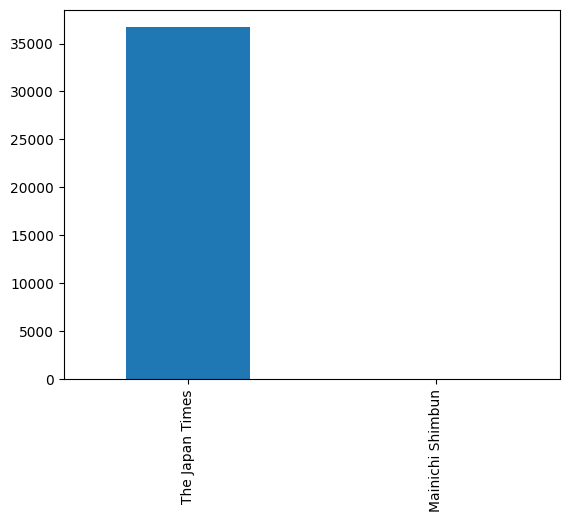

In [11]:
en_source_count = english_news["source"].value_counts()
en_source_count.plot(kind='bar')
en_source_count

##Discussion
The extreme imbalance of the categories and the low number of available texts in the underrepresented category led me to not ocnsider the dataset adequate for a classification task. It could be used for an anomaly detection task, but beofre proceeding or considering such task I moved to the analysis of the Japanese dataset.

# Japanese database exploratory analysis

##Aim
In this section an exploratory data analysis to understand how the dataset in japanese language is composed.

##Methods
Numerosity of articles for each newspaper is presented in a bar plot. Then, visualization of length of articles for each newspaper is described with a boxplot and with a Kernel Density Estimation plot. The length of the articles is evaluated both in terms of string length and token numbers, after the tokenization of each article using the tokenization method found at the state of the art (https://pypi.org/project/fugashi/).

First the identification of missing values is completed.

In [12]:
japanese_news.count()

source    312955
date      312955
title         39
author         1
text      312954
dtype: int64

In [13]:
japanese_news.isna().sum()

source         0
date           0
title     312916
author    312954
text           1
dtype: int64

After the identification of two columns mainly composed of missing values, the two columns are deleted from the dataset. Furthermore, an additional removal of missing values is completed on a row basis, as the potential only one missing value not solved in the dataset could affect the presence of one article's text, basis of our future classifier.

In [14]:
japanese_news = japanese_news.drop(['author','title'],axis=1)

In [15]:
japanese_news = japanese_news.dropna()

I printed an example of article (I choose the first one in the dataset) to understand the text structure.

In [16]:
japanese_news.iloc[0]["text"]

'会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体として判決を厳しく受け止めた」と述べた。原告団長の下村誠治さん（４６）＝神戸市垂水区＝も同席。「県警も判決を真摯（しんし）に受け止めて」と訴えた。'

I plotted a bar plot to visualize the distribution of the articles in the newspapers in the dataset

mainichi.jp          44656
sankei.jp.msn.com    35959
nikkei.com           29323
sanspo.com           26303
tomamin.co.jp        26054
nikkansports.com     25483
oita-press.co.jp     23645
yomiuri.co.jp        22472
nishinippon.co.jp    21311
asahi.com            19855
hokkaido-np.co.jp    10653
shimotsuke.co.jp      9581
kobe-np.co.jp         8311
kyoto-np.co.jp        3408
yamagata-np.jp        2585
isenp.co.jp           1496
iwate-np.co.jp        1198
nnn.co.jp              347
tokachi.co.jp          176
chunichi.co.jp          73
tokyo-np.co.jp          65
Name: source, dtype: int64

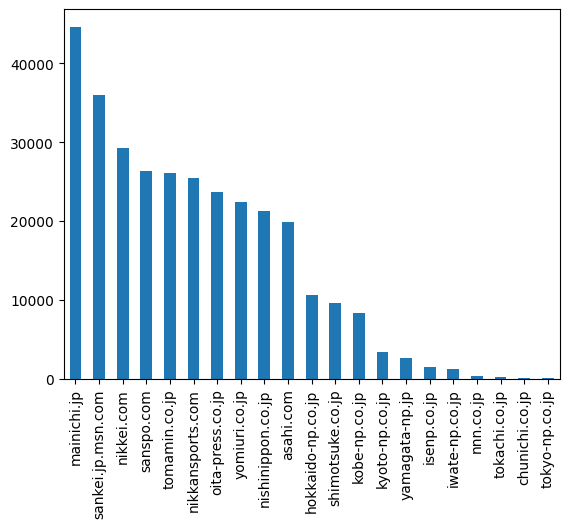

In [17]:
jp_source_count = japanese_news["source"].value_counts()
jp_source_count.plot(kind='bar')
jp_source_count

I calculate and visualize the length of the strings for each newspaper

In [18]:
japanese_news["length"] = japanese_news["text"].str.len()

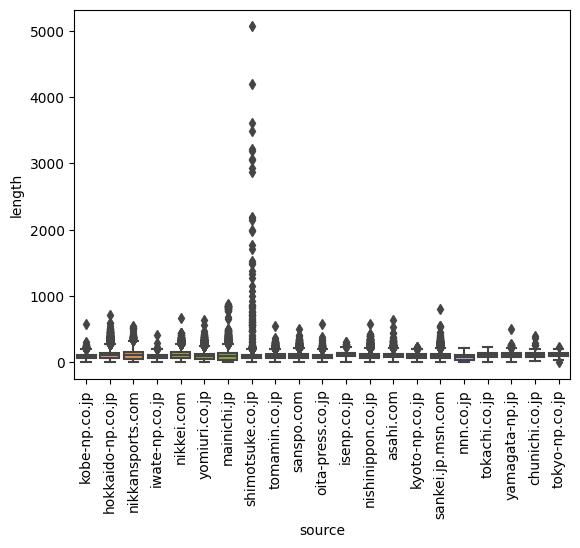

In [19]:
ax = sns.boxplot(data = japanese_news, x='source', y='length')
ax.tick_params(axis='x', labelrotation=90)

I made a focus on a smaller y range to better visualize the boxplots.

(-252.25, 1000.0)

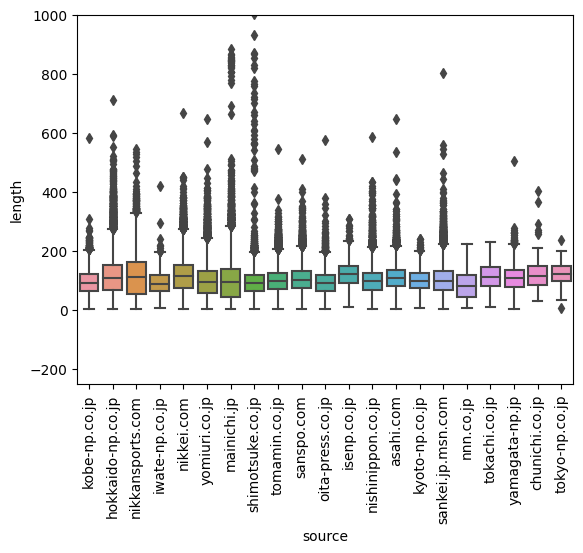

In [20]:
ax = sns.boxplot(data = japanese_news, x='source', y='length')
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(ymax=1000)

I printed the Kernel Density Estimation to visualize the same information provided by the boxplot

<Axes: xlabel='length', ylabel='Density'>

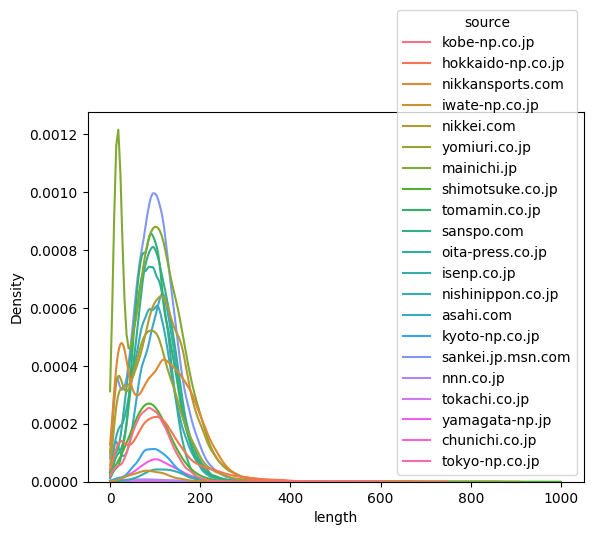

In [21]:
sns.kdeplot(data = japanese_news, x='length',hue=japanese_news['source'], clip=[0,1000])

I tokenized the texts, and printed the first 5 lines of the dataset to visualize the tokenization result.

In [22]:
tagger = Tagger('-Owakati')
japanese_news["tokens"] = japanese_news["text"].apply(tagger.parse)
japanese_news.head()

,source,date,text,length,tokens
0,kobe-np.co.jp,2005-07-01,会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体とし...,117,会見 し た 北口 寛人 市長 は 「 刑事 訴訟 で 被告 と なっ て いる 職員 に ...
1,kobe-np.co.jp,2005-07-01,明石・歩道橋事故をめぐる民事訴訟で、神戸地裁から計五億六千八百万円の賠償を命じられた兵庫県（...,105,明石 ・ 歩道 橋 事故 を めぐる 民事 訴訟 で 、 神戸 地裁 から 計 五 億 六千...
2,kobe-np.co.jp,2007-04-07,会見後、遺族代理人の渡部吉泰弁護士は「裁判長が『問うべき者を問わないのは正義に反する』とはっ...,84,会見 後 、 遺族 代理 人 の 渡部 吉 泰 弁護 士 は 「 裁判 長 が 『 問う べ...
3,kobe-np.co.jp,2007-04-07,遺族会は、雑踏警備本部長を務めた元明石署長ら二人の起訴を求め、活動を続けている。,40,遺族 会 は 、 雑踏 警備 本部 長 を 務め た 元 明石 署 長 ら 二人 の 起訴 ...
4,kobe-np.co.jp,2007-04-07,五人の遺族が閉廷後に会見。二女の優衣菜ちゃん＝当時（８つ）＝を亡くした三木清さん（３８）＝姫...,96,五 人 の 遺族 が 閉廷 後 に 会見 。 二女 の 優衣 菜 ちゃん ＝ 当時 （ ８ ...


I calculated and visualized the length of the articles in terms of number of tokens.

In [23]:
japanese_news["tokens_mat"] = japanese_news["tokens"].str.split(' ')
japanese_news["token_len"]=len(japanese_news["tokens_mat"])

In [24]:
japanese_news["token_len"]=japanese_news["tokens_mat"].apply(len)

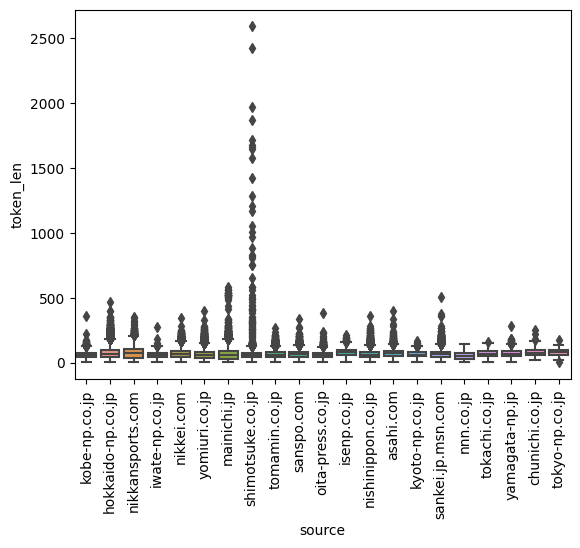

In [25]:
ax = sns.boxplot(data = japanese_news, x='source', y='token_len')
ax.tick_params(axis='x', labelrotation=90)

(-128.45000000000002, 500.0)

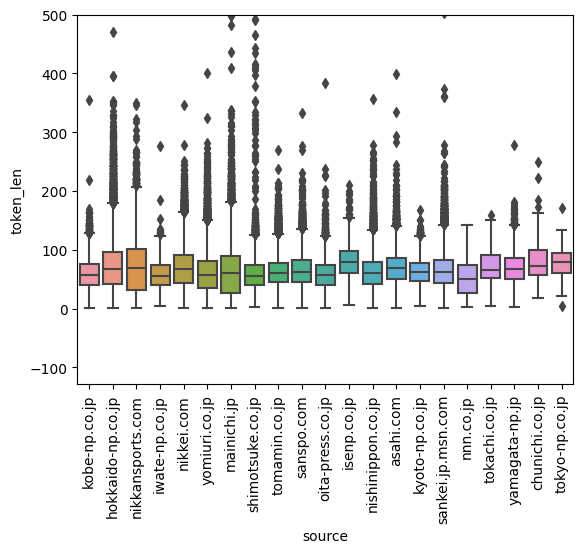

In [26]:
ax = sns.boxplot(data = japanese_news, x='source', y='token_len')
ax.tick_params(axis='x', labelrotation=90)
ax.set_ylim(ymax=500)

<Axes: xlabel='token_len', ylabel='Density'>

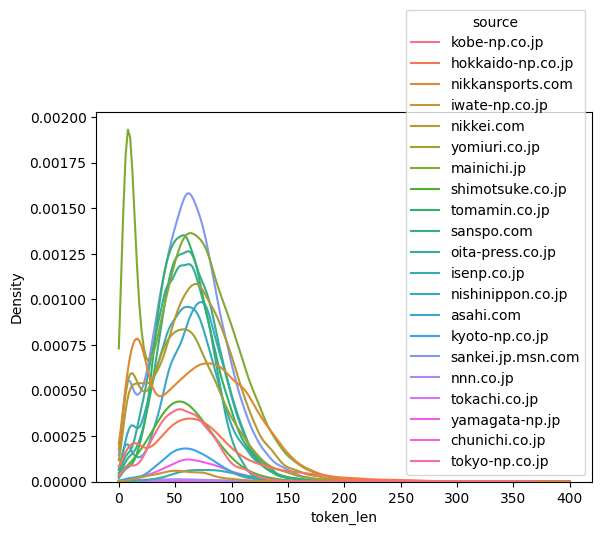

In [27]:
sns.kdeplot(data = japanese_news, x='token_len',hue=japanese_news['source'], clip=[0,400])

##Results
The articles resulted less imbalanced in the japanese dataset. No significant differences among the newspaper is found regarding the length of the articles.

##Discussion
The presence of more balanced categories for a text classification task led me to select this dataset to complete the task.

#Japanese text classification

##Introduction
considering the task, a NLP task, first I had to encode the text and then to identify the best strategy for the classifier. The possibilities considered were the following:

1.   System based on:
  *   Embedding based on the frequency of the tokens in the text (e.g. TF-IDF)
  *   Linear classifier (e.g. SVM)
2.   System based on:
  *   Embedding based on the text semantics using a  transformer pre-trained on the Japanese language
  *   Linear classifier (e.g. SVM)
3.   System based on:
  *   Embedding and classification based on the text semantics using a fine-tuned transformer pre-trained on the Japanese language

  The first and the third approach are completed and descripted in the following steps. Unfortunately, the second approach is not represented here. I considered it the most promising thanks to the possibility to rely on pre-trained complex neural nets like transformers and to rely on a classfier that does not require excessive computational load for training (i.e. SVM), but I had a lot of problems in the memory management, and I was not able to develop it.

##Methods

###First approach

####SVM #1
First a SVM classifier is built using all the tokenized dataset. Performance is evaluated with a confusion matrix and with the performance report provided by Scikit Learn

In [28]:
X = japanese_news["tokens"]
y = japanese_news["source"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)


In [29]:
X_train.shape

(250363, 123407)

In [30]:
X_test = vectorizer.transform(X_test)

In [31]:
X_test.shape

(62591, 123407)

In [32]:
classifier = SGDClassifier(loss='hinge', penalty='l2',
...                           alpha=1e-3, random_state=42,
...                           max_iter=5, tol=None)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.48995862024891756


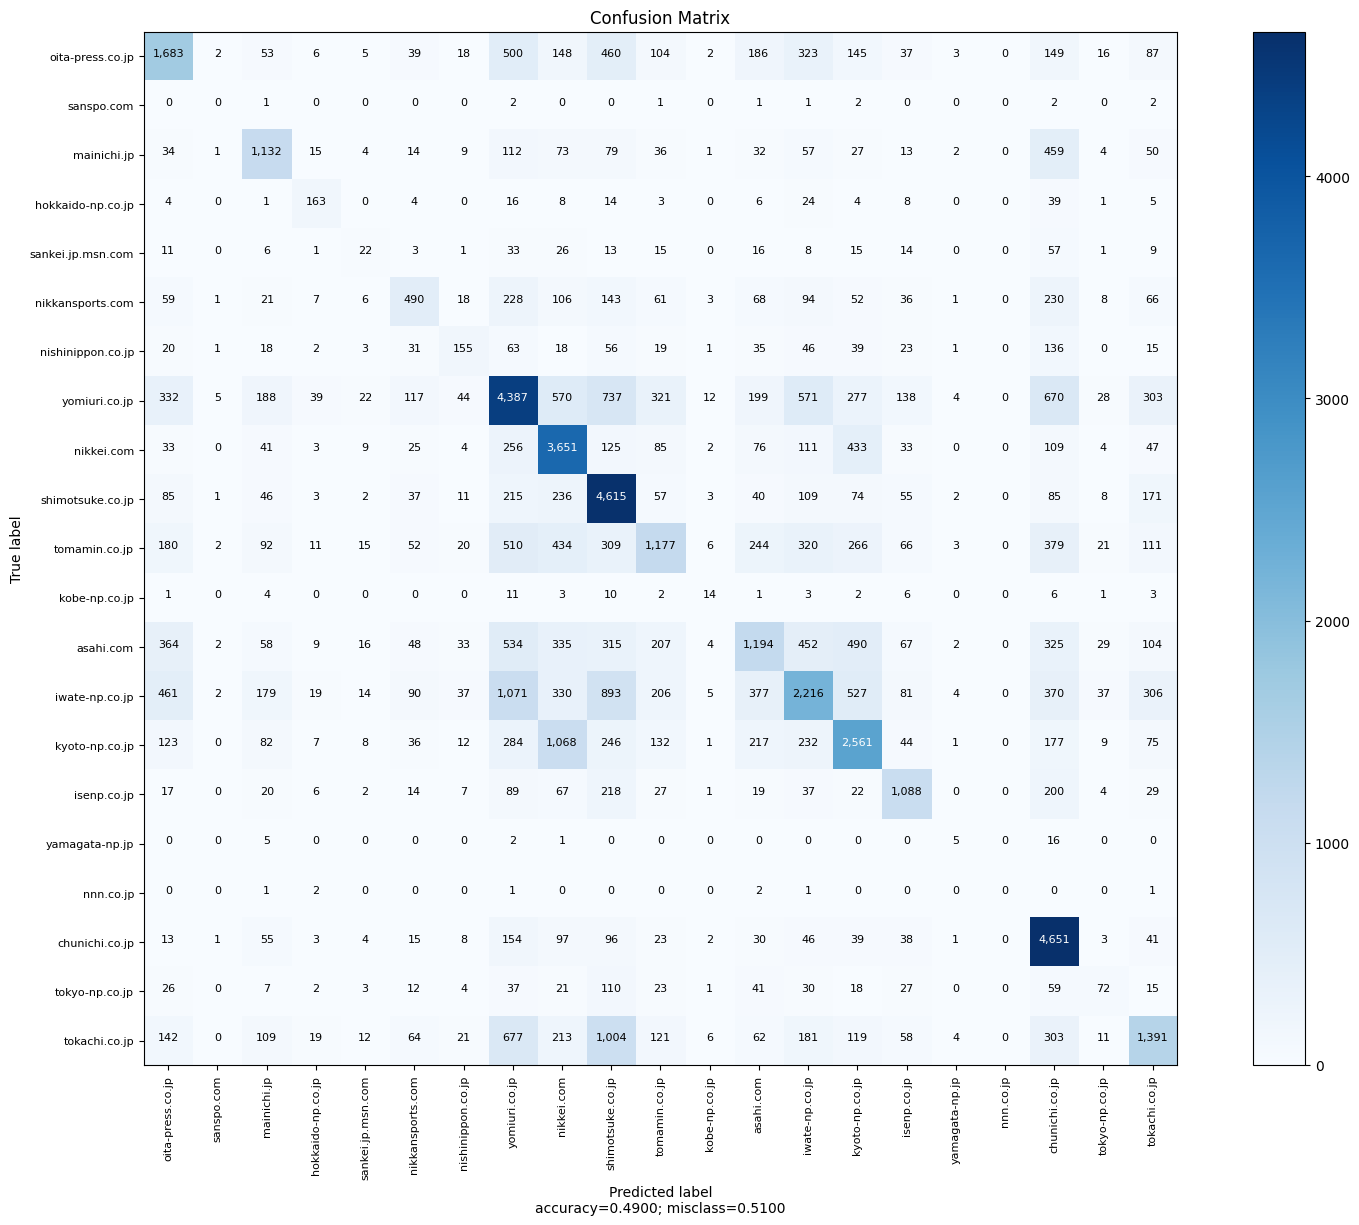

In [33]:
def plot_confusion_matrix_2(cm,
                      target_names,
                      title='Confusion matrix',
                      cmap=None,
                      normalize=True):
  """
  given a sklearn confusion matrix (cm), make a nice plot

  Arguments
  ---------
  cm:           confusion matrix from sklearn.metrics.confusion_matrix

  target_names: given classification classes such as [0, 1, 2]
                the class names, for example: ['high', 'medium', 'low']

  title:        the text to display at the top of the matrix

  cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                see http://matplotlib.org/examples/color/colormaps_reference.html
                plt.get_cmap('jet') or plt.cm.Blues

  normalize:    If False, plot the raw numbers
                If True, plot the proportions


  Citiation
  ---------
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

  """
  FONT_SIZE = 8

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
      cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8*2, 6*2))    # 8, 6
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=90, fontsize=FONT_SIZE)
      plt.yticks(tick_marks, target_names, fontsize=FONT_SIZE)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                  horizontalalignment="center",
                  fontsize=FONT_SIZE,
                  color="white" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                  horizontalalignment="center",
                  fontsize=FONT_SIZE,
                  color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

plot_confusion_matrix_2(confusion_matrix(y_test,y_pred), y_test.unique(), normalize=False, title='Confusion Matrix')

In [34]:
print(classification_report(y_test, y_pred, target_names=y_test.unique()))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                   precision    recall  f1-score   support

 oita-press.co.jp       0.47      0.42      0.45      3966
       sanspo.com       0.00      0.00      0.00        12
      mainichi.jp       0.53      0.53      0.53      2154
hokkaido-np.co.jp       0.51      0.54      0.53       300
sankei.jp.msn.com       0.15      0.09      0.11       251
 nikkansports.com       0.45      0.29      0.35      1698
nishinippon.co.jp       0.39      0.23      0.29       682
    yomiuri.co.jp       0.48      0.49      0.48      8964
       nikkei.com       0.49      0.72      0.59      5047
 shimotsuke.co.jp       0.49      0.79      0.60      5855
    tomamin.co.jp       0.45      0.28      0.34      4218
    kobe-np.co.jp       0.22      0.21      0.21        67
        asahi.com       0.42      0.26      0.32      4588
   iwate-np.co.jp       0.46      0.31      0.37      7225
   kyoto-np.co.jp       0.50      0.48      0.49      5315
      isenp.co.jp       0.59      0.58      0.59      1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


####SVM #2
A SVM classifier is vuilt using the tokenized dataset removing the underrrepresented newspapers (less than 2000 articles. Performance is evaluated with a confusion matrix and with the performance report provided by Scikit Learn

In [35]:
freq = japanese_news["source"].value_counts()<2000
low_freq=freq.loc[freq==True]
low_freq.index.to_list()

['isenp.co.jp',
 'iwate-np.co.jp',
 'nnn.co.jp',
 'tokachi.co.jp',
 'chunichi.co.jp',
 'tokyo-np.co.jp']

In [36]:
jp_news_filt = japanese_news[~japanese_news["source"].isin(low_freq.index.to_list())]

In [37]:
X = jp_news_filt["tokens"]
y = jp_news_filt["source"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)


In [38]:
X_train.shape

(247679, 122724)

In [39]:
X_test = vectorizer.transform(X_test)

In [40]:
X_test.shape

(61920, 122724)

In [41]:
classifier = SGDClassifier(loss='hinge', penalty='l2',
...                           alpha=1e-3, random_state=42,
...                           max_iter=5, tol=None)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.49531653746770027


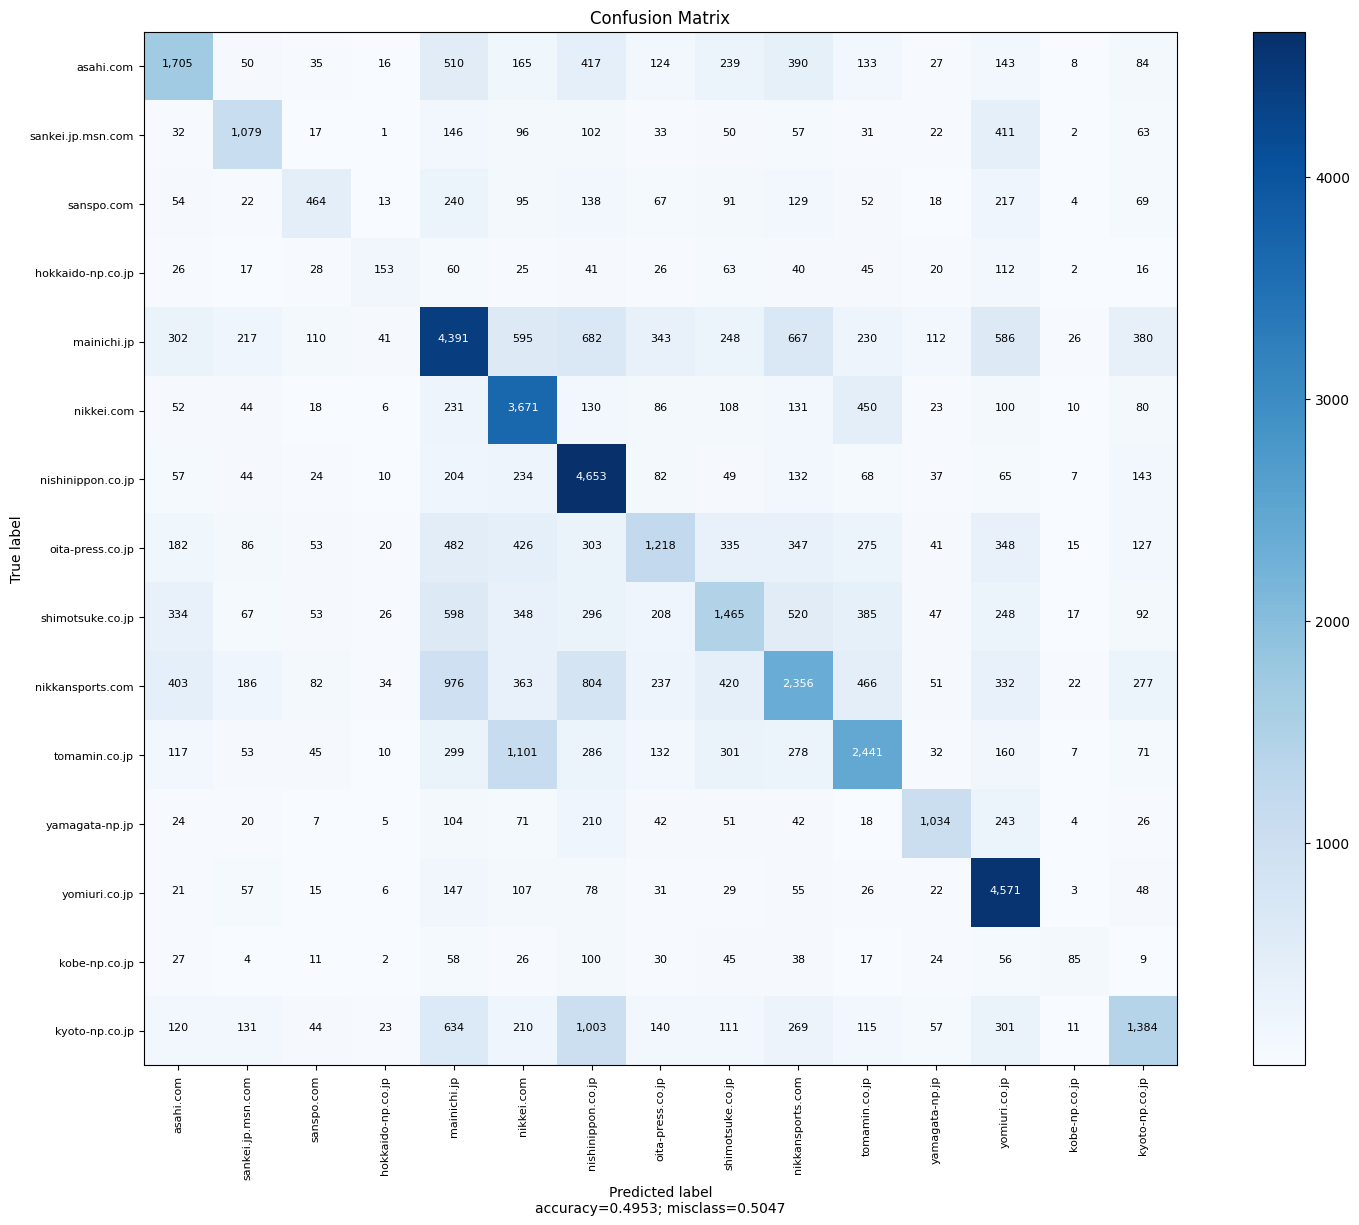

In [42]:
plot_confusion_matrix_2(confusion_matrix(y_test,y_pred), y_test.unique(), normalize=False, title='Confusion Matrix')

In [43]:
print(classification_report(y_test, y_pred, target_names=y_test.unique()))

                   precision    recall  f1-score   support

        asahi.com       0.49      0.42      0.45      4046
sankei.jp.msn.com       0.52      0.50      0.51      2142
       sanspo.com       0.46      0.28      0.35      1673
hokkaido-np.co.jp       0.42      0.23      0.29       674
      mainichi.jp       0.48      0.49      0.49      8930
       nikkei.com       0.49      0.71      0.58      5140
nishinippon.co.jp       0.50      0.80      0.62      5809
 oita-press.co.jp       0.44      0.29      0.35      4258
 shimotsuke.co.jp       0.41      0.31      0.35      4704
 nikkansports.com       0.43      0.34      0.38      7009
    tomamin.co.jp       0.51      0.46      0.48      5333
   yamagata-np.jp       0.66      0.54      0.60      1901
    yomiuri.co.jp       0.58      0.88      0.70      5216
    kobe-np.co.jp       0.38      0.16      0.23       532
   kyoto-np.co.jp       0.48      0.30      0.37      4553

         accuracy                           0.50     6

####SVM #3
A SVM classifier is built using the tokenized dataset removing the underrrepresented newspapers (less than 2000 articles and removing from the tokenized dataset all the stopwords in the japanese language to reduce the number of recurrent words not providing additional info. Performance is evaluated with a confusion matrix and with the performance report provided by Scikit Learn

In [44]:
slothlib_path = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
sloth_file = urllib.request.urlopen(slothlib_path)

iso_path = "https://raw.githubusercontent.com/stopwords-iso/stopwords-ja/master/stopwords-ja.txt"
iso_file = urllib.request.urlopen(iso_path)
stopwords = [line.decode("utf-8").strip() for line in iso_file]

stopwords = [ss for ss in stopwords if not ss==u'']
stopwords = list(set(stopwords))

In [45]:
X = jp_news_filt["tokens"]
y = jp_news_filt["source"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)
vectorizer = TfidfVectorizer(stop_words=stopwords)
X_train = vectorizer.fit_transform(X_train)

In [46]:
X_train.shape

(247679, 122652)

In [47]:
X_test = vectorizer.transform(X_test)

In [48]:
X_test.shape

(61920, 122652)

In [49]:
classifier = SGDClassifier(loss='hinge', penalty='l2',
...                           alpha=1e-3, random_state=42,
...                           max_iter=5, tol=None)

classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.49249031007751937


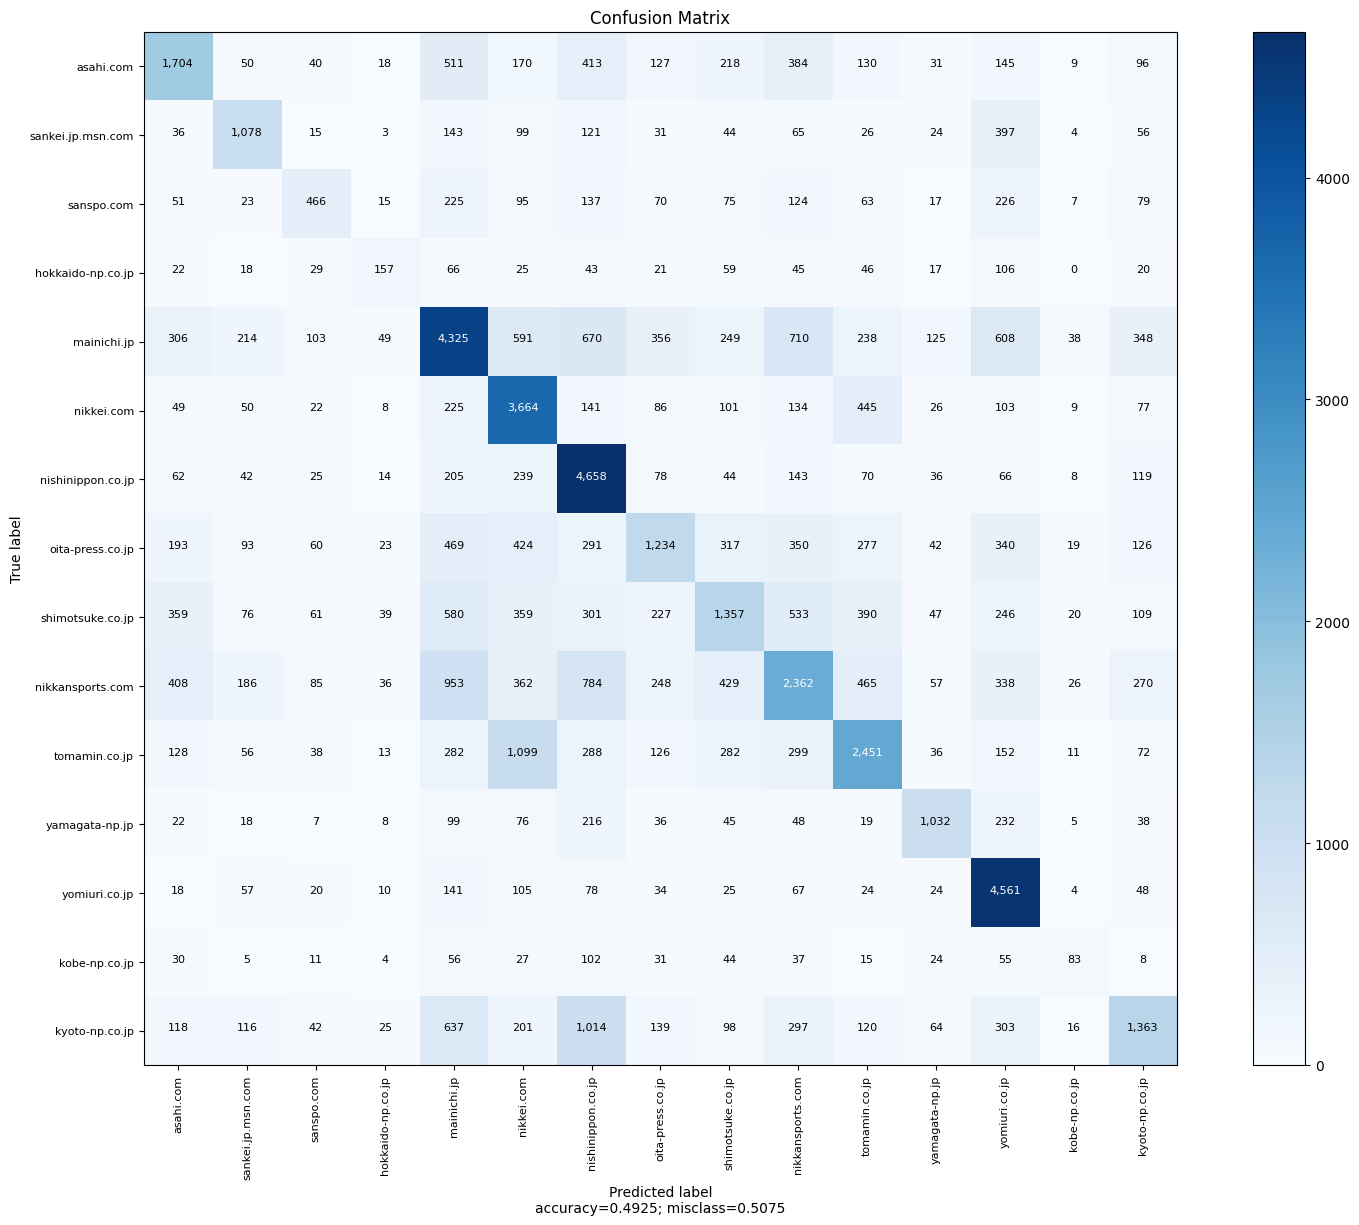

In [50]:
plot_confusion_matrix_2(confusion_matrix(y_test,y_pred), y_test.unique(), normalize=False, title='Confusion Matrix')

###Second Approach



####Transformer
A BERT model is built finetuning a pretrained model trained on the Japanese portion of CC-100 dataset and the Japanese version of Wikipedia for text classification.

#####Training

In [ ]:
possible_labels = japanese_news["source"].unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [ ]:
japanese_news['label'] = japanese_news["source"].replace(label_dict)

In [ ]:
dataset = Dataset.from_pandas(japanese_news.filter(["text","label"]))

In [ ]:
## Split data into train and test

df = japanese_news[["text", "label"]]

X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
print(df[df['data_type'] == "train"]["label"].nunique())
print(df[df['data_type'] == "val"]["label"].nunique())

a = set(df[df['data_type'] == "train"]["label"].unique())
b = set(df[df['data_type'] == "train"]["label"].unique())

print(len(a), len(b), len(a.intersection(b)))

21
21
21 21 21


<ipython-input-52-2d22c6782656>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_type'] = ['not_set']*df.shape[0]


In [ ]:
df.head()

,text,label,data_type
0,会見した北口寛人市長は「刑事訴訟で被告となっている職員にはそれぞれ主張があるが、組織全体とし...,0,train
1,明石・歩道橋事故をめぐる民事訴訟で、神戸地裁から計五億六千八百万円の賠償を命じられた兵庫県（...,0,train
2,会見後、遺族代理人の渡部吉泰弁護士は「裁判長が『問うべき者を問わないのは正義に反する』とはっ...,0,train
3,遺族会は、雑踏警備本部長を務めた元明石署長ら二人の起訴を求め、活動を続けている。,0,val
4,五人の遺族が閉廷後に会見。二女の優衣菜ちゃん＝当時（８つ）＝を亡くした三木清さん（３８）＝姫...,0,val


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from transformers import BertJapaneseTokenizer

tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-v3', device=0)

def tokenization(example):
    return tokenizer(example["text"],add_special_tokens=True,
                     return_attention_mask=True,
                     padding='max_length',
                     return_tensors='pt',
                     truncation='longest_first')

dataset = Dataset.from_pandas(df)
train_data = dataset.filter(lambda example: example["data_type"]=="train")
val_data = dataset.filter(lambda example: example["data_type"]=="val")
train_data = train_data.map(tokenization, batched=True)
val_data = val_data.map(tokenization, batched=True)

Filter:   0%|          | 0/312954 [00:00<?, ? examples/s]

Filter:   0%|          | 0/312954 [00:00<?, ? examples/s]

Map:   0%|          | 0/250363 [00:00<?, ? examples/s]

Map:   0%|          | 0/62591 [00:00<?, ? examples/s]

In [ ]:
train_data.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])
val_data.set_format(type="torch", columns=["input_ids", "token_type_ids", "attention_mask", "label"])

In [ ]:
len(label_dict)

21

In [ ]:
## Define model
model = BertForSequenceClassification.from_pretrained("cl-tohoku/bert-base-japanese-v3",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

# model.parameters

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-v3 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(output_dir=dataset_path+"/test_trainer")
metric = evaluate.load("accuracy")
f1_none = evaluate.load("f1",average=None)
f1_micro = evaluate.load("f1",average="micro")
f1_macro = evaluate.load("f1",average="macro")
f1_weighted = evaluate.load("f1",average="weighted")
recall_none = evaluate.load("recall",average=None)
recall_micro = evaluate.load("recall",average="micro")
recall_macro = evaluate.load("recall",average="macro")
recall_weighted = evaluate.load("recall",average="weighted")
precision_none = evaluate.load("precision",average=None)
precision_micro = evaluate.load("precision",average="micro")
precision_macro = evaluate.load("precision",average="macro")
precision_weighted = evaluate.load("precision",average="weighted")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    metric=evaluate.combine(["accuracy", recall_none, recall_micro,
                             recall_macro, recall_weighted, precision_none,
                             precision_micro, precision_macro,
                             precision_weighted, f1_none, f1_micro, f1_macro,
                             f1_weighted, "matthews_correlation", "pearsonr",])
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(output_dir=dataset_path+"/test_trainer", evaluation_strategy="epoch")


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
)

In [ ]:
#trainer.train(resume_from_checkpoint=True)

In [ ]:
#trainer.save_model(dataset_path)

#####Evaluation

In [51]:
possible_labels = japanese_news["source"].unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [52]:
japanese_news['label'] = japanese_news["source"].replace(label_dict)

In [53]:
dataset = Dataset.from_pandas(japanese_news.filter(["text","label"]))

In [54]:
## Split data into train and test

df = japanese_news[["text", "label"]]

X_train, X_val, y_train, y_val = train_test_split(df.index.values,
                                                  df.label.values,
                                                  test_size=0.2,
                                                  random_state=42,
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_val, 'data_type'] = 'val'
print(df[df['data_type'] == "train"]["label"].nunique())
print(df[df['data_type'] == "val"]["label"].nunique())

a = set(df[df['data_type'] == "train"]["label"].unique())
b = set(df[df['data_type'] == "train"]["label"].unique())

print(len(a), len(b), len(a.intersection(b)))

21
21
21 21 21


<ipython-input-54-2d22c6782656>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['data_type'] = ['not_set']*df.shape[0]


In [55]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data import TensorDataset
from transformers import BertJapaneseTokenizer

tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-v3', device=0)

def tokenization(example):
    return tokenizer(example["text"],add_special_tokens=True,
                     return_attention_mask=True,
                     padding='max_length',
                     return_tensors='pt',
                     truncation='longest_first')

dataset = Dataset.from_pandas(df)
train_data = dataset.filter(lambda example: example["data_type"]=="train")
val_data = dataset.filter(lambda example: example["data_type"]=="val")
train_data = train_data.map(tokenization, batched=True)
val_data = val_data.map(tokenization, batched=True)
#val_data.save_to_disk(dataset_path+"/val")

Filter:   0%|          | 0/312954 [00:00<?, ? examples/s]

Filter:   0%|          | 0/312954 [00:00<?, ? examples/s]

Map:   0%|          | 0/250363 [00:00<?, ? examples/s]

Map:   0%|          | 0/62591 [00:00<?, ? examples/s]

In [56]:
training_args = TrainingArguments(output_dir=dataset_path+"/test_trainer")
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
f1_none = evaluate.load("f1",average=None)
f1_micro = evaluate.load("f1",average="micro")
f1_macro = evaluate.load("f1",average="macro")
f1_weighted = evaluate.load("f1",average="weighted")
recall_none = evaluate.load("recall",average=None)
recall_micro = evaluate.load("recall",average="micro")
recall_macro = evaluate.load("recall",average="macro")
recall_weighted = evaluate.load("recall",average="weighted")
precision_none = evaluate.load("precision",average=None)
precision_micro = evaluate.load("precision",average="micro")
precision_macro = evaluate.load("precision",average="macro")
precision_weighted = evaluate.load("precision",average="weighted")
accuracy = evaluate.load("accuracy")
matthews_none = evaluate.load("matthews_correlation", average=None)
matthews_macro = evaluate.load("matthews_correlation", average="macro")
pearson = evaluate.load("pearsonr")

In [57]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    results = {}
    results.update(accuracy.compute(predictions=predictions, references = labels))
    results.update(recall_none.compute(predictions=predictions, references = labels, average="micro"))
    results.update(precision_none.compute(predictions=predictions, references = labels, average="micro"))
    results.update(f1_none.compute(predictions=predictions, references = labels, average="micro"))
    results.update(matthews_none.compute(predictions=predictions, references = labels, average="macro"))
    results.update(pearson.compute(predictions=predictions, references = labels))
    return results

training_args = TrainingArguments(output_dir=dataset_path+"/test_trainer", evaluation_strategy="epoch")


In [58]:
model = BertForSequenceClassification.from_pretrained(dataset_path)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    compute_metrics=compute_metrics,
)

In [59]:
temp = val_data.shuffle()
temp = temp.select(range(100))
#trainer.evaluate()

In [60]:
temp

Dataset({
    features: ['text', 'label', 'data_type', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 100
})

In [ ]:
trainer.evaluate()

Using bos_token, but it is not set yet.
Using eos_token, but it is not set yet.


{'eval_loss': 1.1825964450836182,
 'eval_accuracy': 0.6724289434583247,
 'eval_recall': 0.6724289434583247,
 'eval_precision': 0.6724289434583247,
 'eval_f1': 0.6724289434583247,
 'eval_matthews_correlation': 0.641866482327084,
 'eval_pearsonr': 0.6329706068752959,
 'eval_runtime': 504.228,
 'eval_samples_per_second': 124.132,
 'eval_steps_per_second': 15.517}

In [61]:
out=trainer.predict(test_dataset=val_data)

In [87]:
predictions = out.predictions
labels = out[1]

In [97]:
predicted_labels = np.argmax(predictions, axis=1)

In [100]:
label_dict

{'kobe-np.co.jp': 0,
 'hokkaido-np.co.jp': 1,
 'nikkansports.com': 2,
 'iwate-np.co.jp': 3,
 'nikkei.com': 4,
 'yomiuri.co.jp': 5,
 'mainichi.jp': 6,
 'shimotsuke.co.jp': 7,
 'tomamin.co.jp': 8,
 'sanspo.com': 9,
 'oita-press.co.jp': 10,
 'isenp.co.jp': 11,
 'nishinippon.co.jp': 12,
 'asahi.com': 13,
 'kyoto-np.co.jp': 14,
 'sankei.jp.msn.com': 15,
 'nnn.co.jp': 16,
 'tokachi.co.jp': 17,
 'yamagata-np.jp': 18,
 'chunichi.co.jp': 19,
 'tokyo-np.co.jp': 20}

In [103]:
inv_label_dict = dict((v, k) for k, v in label_dict.items())

In [108]:
label_df = pd.DataFrame()
label_df["labels"]=labels
label_df["predictions"]=predicted_labels

In [109]:
label_df["labels"]=label_df["labels"].replace(inv_label_dict)
label_df["predictions"]=label_df["predictions"].replace(inv_label_dict)

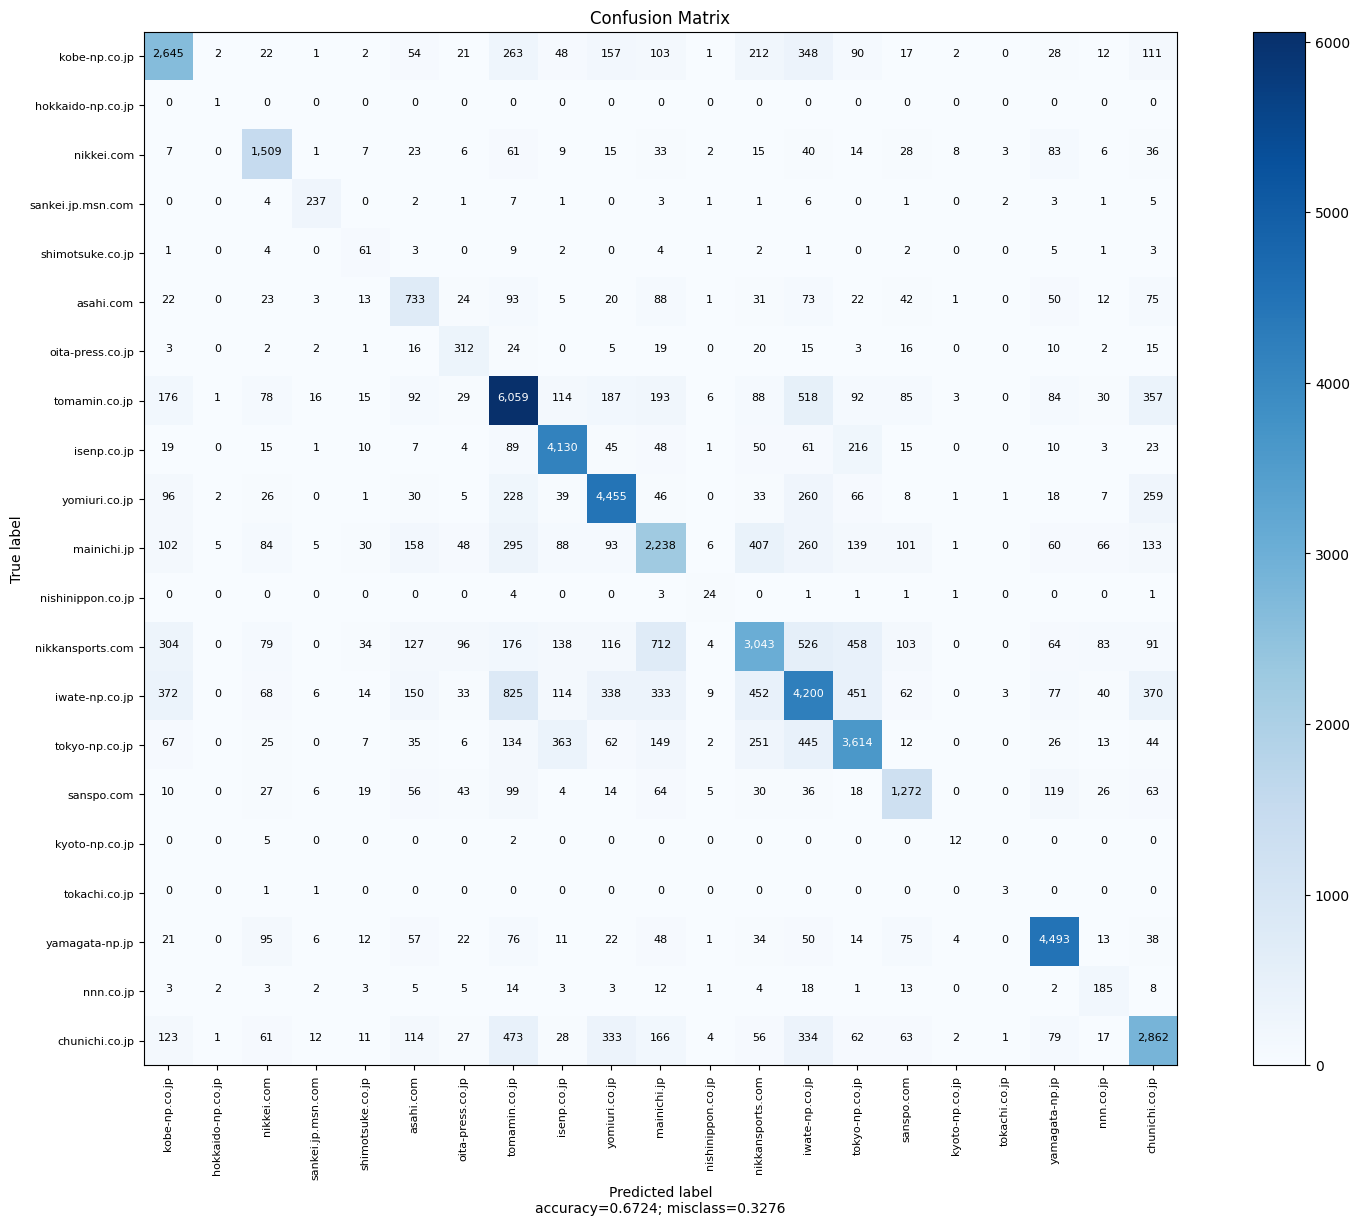

In [111]:
plot_confusion_matrix_2(confusion_matrix(label_df["predictions"],label_df["labels"]), label_df["predictions"].unique(), normalize=False, title='Confusion Matrix')

In [112]:
print(classification_report(label_df["labels"],label_df["predictions"], target_names=label_df["labels"].unique()))

                   precision    recall  f1-score   support

    kobe-np.co.jp       0.64      0.67      0.65      3971
hokkaido-np.co.jp       1.00      0.07      0.13        14
 nikkansports.com       0.79      0.71      0.75      2131
   iwate-np.co.jp       0.86      0.79      0.83       299
       nikkei.com       0.62      0.25      0.36       240
    yomiuri.co.jp       0.55      0.44      0.49      1662
      mainichi.jp       0.67      0.46      0.54       682
 shimotsuke.co.jp       0.74      0.68      0.71      8931
    tomamin.co.jp       0.87      0.81      0.84      5097
       sanspo.com       0.80      0.76      0.78      5865
 oita-press.co.jp       0.52      0.53      0.52      4262
      isenp.co.jp       0.67      0.35      0.46        69
nishinippon.co.jp       0.49      0.64      0.56      4729
        asahi.com       0.53      0.58      0.56      7192
   kyoto-np.co.jp       0.69      0.69      0.69      5261
sankei.jp.msn.com       0.67      0.66      0.66      1

##Results

All the SVMs did not provide excellent results. The classifier classified less than half of the samples correctly, and all further activities such as reducing the number of classes eliminating the classes with less than 2000 articles and removing the stopwords did not improve significantly the performances. A suboptimal performance is expected, as a system based on word frequency may be flawed by the necessity of newspapers to present news and actual facts, reducing the potential variation in the dictionary. On the other hand the transformer, thanks to its capacity to represent semantically the words, provided an increased accuracy up to 67%.
As said before, in this notebook the approach considered most interesting and promising is not tested, as I had troubles in the RAM management.

##Discussion

The results shown here provide a suggestion for future improvements. In fact, even if the results are not optimal, a lot of improvements in the system can be planned to increase accuracy. The proposal for the future improvements can be listed as follows:


*   Implementation of Grid Search for optimal parameters for the SVM training
*   Implementation of SVMs on top of BERT embeddings
*   Further training of the transformer and search for optimal hyperparameters.

